# Exercise 6 + Homework 3: MLPs + Dropout + CNNs

Much of this was taken from DS-GA 1011 course from last semester.

### Data things

We're doing a sentiment classification task. So first load the Stanford Sentiment Treebank data.

In [167]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [168]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import re
import random

random.seed(1)
sst_home = 'data/trees'

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}
    # so labels of 0 and 1 in the 5-way classificaiton are 0 in the 2-way. 3 and 4 are 1, and 2 is none
    # because we don't have a neutral class. 

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data
     
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

And extract bag-of-words feature vectors. For speed, we'll only use words that appear at least 25 times in the training set, leaving us with |V|=1254.

In [169]:
import collections
import numpy as np

def tokenize(string):
    return string.split()

def build_dictionary(training_datasets):
    """
    Extract vocabulary and build dictionary.
    """  
    word_counter = collections.Counter()
    for i, dataset in enumerate(training_datasets):
        for example in dataset:
            word_counter.update(tokenize(example['text']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))

    return word_indices, len(vocabulary)

def sentences_to_padded_index_sequences(word_indices, datasets):
    """
    Annotate datasets with feature vectors. Adding right-sided padding. 
    """
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['text_index_sequence'] = torch.zeros(max_seq_length)

            token_sequence = tokenize(example['text'])
            padding = max_seq_length - len(token_sequence)

            for i in range(max_seq_length):
                if i >= len(token_sequence):
                    index = word_indices[PADDING]
                    pass
                else:
                    if token_sequence[i] in word_indices:
                        index = word_indices[token_sequence[i]]
                    else:
                        index = word_indices[UNKNOWN]
                example['text_index_sequence'][i] = index

            example['text_index_sequence'] = example['text_index_sequence'].long().view(1,-1)
            example['label'] = torch.LongTensor([example['label']])


word_to_ix, vocab_size = build_dictionary([training_set])
sentences_to_padded_index_sequences(word_to_ix, [training_set, dev_set, test_set])

We want to feed data to our model in mini-batches so we need a data iterator that will "batchify" the data.

In [170]:
# This is the iterator we'll use during training. 
# It's a generator that gives you one batch at a time.
def data_iter(source, batch_size):
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            # Start another epoch.
            start = 0
            random.shuffle(order)   
        batch_indices = order[start:start + batch_size]
        yield [source[index] for index in batch_indices]

# This is the iterator we use when we're evaluating our model. 
# It gives a list of batches that you can then iterate through.
def eval_iter(source, batch_size):
    batches = []
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while start < dataset_size - batch_size:
        start += batch_size
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        batches.append(batch)
        
    return batches

# The following function gives batches of vectors and labels, 
# these are the inputs to your model and loss function
def get_batch(batch):
    vectors = []
    labels = []
    for dict in batch:
        vectors.append(dict["text_index_sequence"])
        labels.append(dict["label"])
    return vectors, labels


### Model time!

We need to define an evaluation function,

In [171]:
def evaluate(model, data_iter):
    model.eval()
    correct = 0
    total = 0
    for i in range(len(data_iter)):
        vectors, labels = get_batch(data_iter[i])
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = torch.stack(labels).squeeze()
        output = model(vectors)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return correct / float(total)

Below is a multilayer perceptron classifier.

What hyperparameters do you think would work well?

In [172]:
# A Multi-Layer Perceptron (MLP)
class MLPClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, input_size, embedding_dim, hidden_dim, num_labels, dropout_prob):
        super(MLPClassifier, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p=dropout_prob)
            
        self.linear_1 = nn.Linear(embedding_dim, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_3 = nn.Linear(hidden_dim, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = torch.sum(out, dim=1)
        out = F.relu(self.linear_1(out))
        out = F.relu(self.linear_2(out))
        out = self.dropout(self.linear_3(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear_1, self.linear_2]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

We now define our training loop,

In [281]:
def training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=False):
    step = 0

    for i in range(num_train_steps):
        model.train()
        vectors, labels = get_batch(next(training_iter))
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = Variable(torch.stack(labels).squeeze())

        model.zero_grad()
        output = model(vectors)

        lossy = loss(output, labels)
        lossy.backward()
        optimizer.step()

        if (step % 100 == 0):
            if not acc:
                print( "Step %i; Loss %f; Train acc: %f; Dev acc %f" 
                    %(step, lossy.data[0], evaluate(model, train_eval_iter), evaluate(model, dev_iter)))
            # Save accuracies for plotting
            train_acc = evaluate(model, train_eval_iter)
            dev_acc = evaluate(model, dev_iter)

        step += 1
        
    if acc:
        return train_acc, dev_acc

Let's define our hyperparameters

In [174]:
# Hyperparameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

Modify these hyperparameters to try to achieve approximately 80% dev accuracy.

In [372]:
# Feed-forward (modified to use best parameters)
hidden_dim = 80
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

Finally, we can build and train our model!

In [374]:
model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.697986; Train acc: 0.486000; Dev acc 0.472000
Step 100; Loss 0.781940; Train acc: 0.602000; Dev acc 0.592000
Step 200; Loss 0.669699; Train acc: 0.750000; Dev acc 0.752000
Step 300; Loss 0.432886; Train acc: 0.794000; Dev acc 0.738000
Step 400; Loss 0.483194; Train acc: 0.884000; Dev acc 0.808000
Step 500; Loss 0.428701; Train acc: 0.892000; Dev acc 0.780000
Step 600; Loss 0.560667; Train acc: 0.916000; Dev acc 0.778000
Step 700; Loss 0.348382; Train acc: 0.932000; Dev acc 0.764000
Step 800; Loss 0.205589; Train acc: 0.932000; Dev acc 0.790000
Step 900; Loss 0.278379; Train acc: 0.956000; Dev acc 0.786000


Let's see how it performs on the held out test set,

In [375]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(model, test_iter)
print('Accuracy of the CBOW on the test data: %f' % (test_acc))

Accuracy of the CBOW on the test data: 0.772652


<br>
This model does okay. It doesn't do that well. Let's try and define a Convolutional Neural Network to try and improve performance.

In [215]:
class TextCNN(nn.Module):
    def __init__(self, input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob):
        super(TextCNN, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.dropout2 = nn.Dropout(p = dropout_prob)
        self.conv1 = nn.Conv2d(1, n_filters, (window_size, embedding_dim)) 
        self.fc1 = nn.Linear(n_filters, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = out.unsqueeze(1)
        out = self.conv1(out).squeeze(3)
        out = F.relu(out)
        out = F.max_pool1d(out, out.size(2)).squeeze(2)
        out = self.fc1(self.dropout2(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.fc1]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

Let's train our Conv Net. Let's redefine the hyperparameters here. You need to modify these as well! Try to achieve approximately 80% dev accuracy.

In [349]:
# CNN (modified to use best parameters)
window_size = 5
n_filters = 50
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

Lets build and train this model:

In [350]:
cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)
    
# Loss and Optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Train the model
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[0:500], batch_size)
training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.689773; Train acc: 0.482000; Dev acc 0.470000
Step 100; Loss 0.685961; Train acc: 0.514000; Dev acc 0.528000
Step 200; Loss 0.649856; Train acc: 0.570000; Dev acc 0.590000
Step 300; Loss 0.654968; Train acc: 0.708000; Dev acc 0.690000
Step 400; Loss 0.481353; Train acc: 0.824000; Dev acc 0.774000
Step 500; Loss 0.348207; Train acc: 0.862000; Dev acc 0.786000
Step 600; Loss 0.401833; Train acc: 0.912000; Dev acc 0.796000
Step 700; Loss 0.288229; Train acc: 0.934000; Dev acc 0.814000
Step 800; Loss 0.339726; Train acc: 0.950000; Dev acc 0.794000
Step 900; Loss 0.098882; Train acc: 0.968000; Dev acc 0.778000


Lets evaluate this on the held out test set

In [351]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(cnn_model, test_iter)
print('Accuracy of the CNN model on the test data: %f' % (test_acc))

Accuracy of the CNN model on the test data: 0.777595


# Homework 3 (10pts)

### Please construct all of your plots in the ipython notebook using something like matplotlib. Provide all answers in the ipython notebook. We will not grade anything other than the ipython notebook

Questions:

1. Provide plots of varying hidden_dim, embedding_dim, LR, and dropout for deep CBOW (0.75pts each). 
2. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
3. Provide plots of varying embedding_dim, window_size, num_filters, LR, and dropout for CNN (0.6pts for each HP).
4. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
5. Write down an hyperparameter configuration for CBOW that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).
6. Write down an hyperparameter configuration for CNN that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).

### 1.

To generate the plots, we will only vary the hyperparameter we are currently interested in. The remaining hyperparameters are kept fixed to their previously best-performing setting. The range of values to be run for each hyperparameter is specified in `val_range`.

I was debating whether or not to take the average of the train/dev accuracies across all time steps, or use the best train/dev accuracy at one specific time step. In the end I decided to compare train/dev accuracies at the _final step_ of training.

The plotted y-axes are scaled between 0.5-1.0. Since accuracies around 0.5 reflect random chance, we are generally expecting to see results better than that.

In [340]:
# Fixed hyper-parameters
hidden_dim = 80
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

# Range of values to test
val_range = {
    "hidden_dim": [5, 50, 80, 100, 150, 200],
    "embedding_dim": [10, 20, 50, 100, 150, 200, 300],
    "learning_rate": [0.00001, 0.0001, 0.001, 0.1, 1],
    "dropout_prob": [0.1, 0.25, 0.5, 0.75, 0.9],
}

#### hidden_dim

   hidden_dim  train_acc  dev_acc
0         5.0      0.966    0.778
1        50.0      0.952    0.790
2        80.0      0.960    0.776
3       100.0      0.968    0.782
4       150.0      0.950    0.804
5       200.0      0.960    0.790


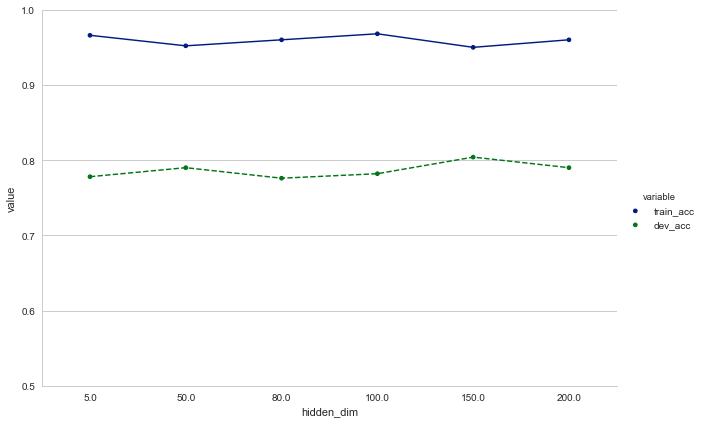

In [341]:
df_hidden_dim = pd.DataFrame(columns=["hidden_dim", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["hidden_dim"]):
    # Model specification
    model = MLPClassifier(input_size, embedding_dim, x, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_hidden_dim.loc[idx] = [x, train_acc, dev_acc]
print(df_hidden_dim)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_hidden_dim, id_vars=["hidden_dim"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="hidden_dim", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=6).set(ylim=(0.5, 1))

#### embedding_dim

   embedding_dim  train_acc  dev_acc
0           10.0      0.920    0.804
1           20.0      0.942    0.802
2           50.0      0.934    0.792
3          100.0      0.942    0.776
4          150.0      0.954    0.770
5          200.0      0.968    0.792
6          300.0      0.948    0.758


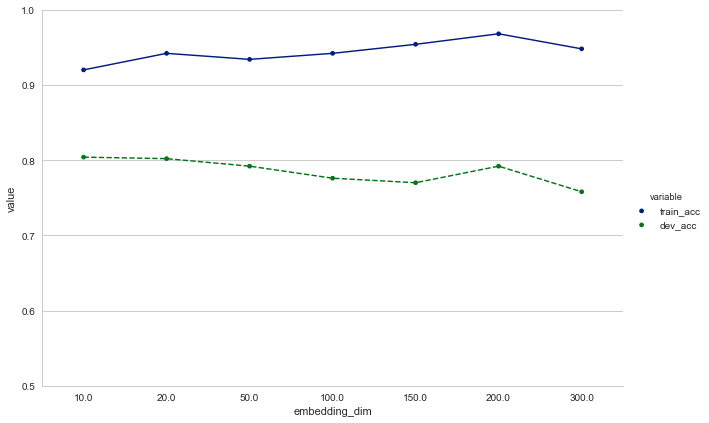

In [352]:
df_embedding_dim = pd.DataFrame(columns=["embedding_dim", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["embedding_dim"]):
    # Model specification
    model = MLPClassifier(input_size, x, hidden_dim, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_embedding_dim.loc[idx] = [x, train_acc, dev_acc]
print(df_embedding_dim)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_embedding_dim, id_vars=["embedding_dim"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="embedding_dim", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=6).set(ylim=(0.5, 1))

#### learning_rate

   learning_rate  train_acc  dev_acc
0        0.00001      0.514    0.528
1        0.00010      0.686    0.688
2        0.00100      0.970    0.752
3        0.10000      0.514    0.528
4        1.00000      0.514    0.530


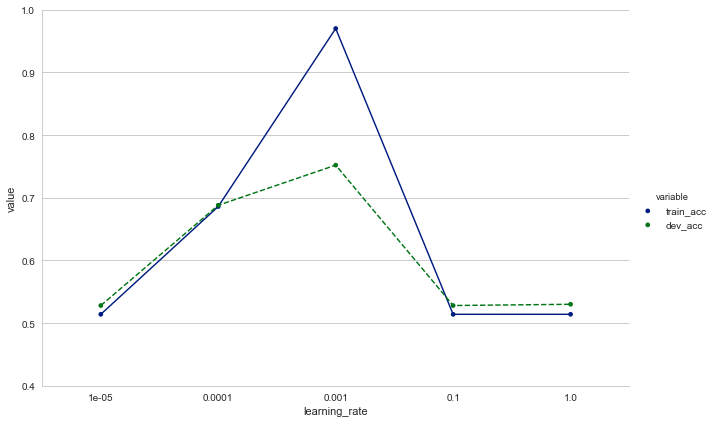

In [353]:
df_learning_rate = pd.DataFrame(columns=["learning_rate", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["learning_rate"]):
    # Model specification
    model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=x)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_learning_rate.loc[idx] = [x, train_acc, dev_acc]
print(df_learning_rate)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_learning_rate, id_vars=["learning_rate"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="learning_rate", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=6).set(ylim=(0.4, 1))  # Scaling exception

#### dropout_prob

   dropout_prob  train_acc  dev_acc
0          0.10      0.994    0.766
1          0.25      0.988    0.752
2          0.50      0.968    0.788
3          0.75      0.844    0.748
4          0.90      0.584    0.568


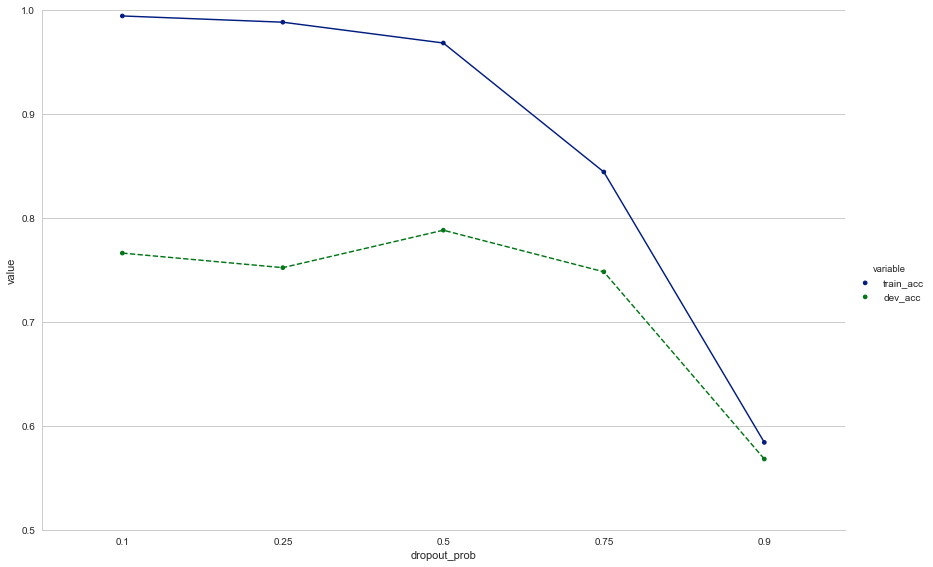

In [354]:
df_dropout_prob = pd.DataFrame(columns=["dropout_prob", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["dropout_prob"]):
    # Model specification
    model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, x)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_dropout_prob.loc[idx] = [x, train_acc, dev_acc]
print(df_dropout_prob)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_dropout_prob, id_vars=["dropout_prob"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="dropout_prob", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.5, 1))

### 2.

First of all I would like to note that the order in which these hyperparameters are optimized can make a big difference in the overall tuning outcome. For the purpose of this exercise, I have kept the parameters in the same order in which they were originally introduced.

For `hidden_dim`, the best overall dev performance was achieved when setting `hidden_dim = 80`. I evaluated the following `hidden_dim` values: `[5, 50, 80, 100, 150, 200]`. From the plot it seems that varying `hidden_dim` does not have a significant effect on the train accuracy. Dev accuracy varies a little more for each value, but the upward/downward trends keep changing with every evaluation run. Based on the empirical results, I am not convinced that tuning the `hidden_dim` parameter has a meaningful impact on the model accuracy on either train or dev in this case.

For `embedding_dim`, the best overall dev performace was achieved when setting `embedding_dim = 100`. Based on this, I evaluated the following `embedding_dim` values as well: `[10, 20, 50, 100, 150, 200, 300]`. From the plot, it seems that the model easily overfits to the training data the higher the number of dimensions, as indicated by the mostly inverse correlation between train and dev accuracy. Setting `embedding_dim = 200` appears to be an exception since both train and dev accuracy suddenly improve. Setting `embedding_dim = 300` seems to worsen the results again. Again, I am not confident that the empirical results accurately reflect the real effect of tuning the `embedding_dim` parameter. However, it does seem that for this specific task and the relatively small dataset, setting `embedding_dim <= 100` generally tends to lead to a higher model accuracy. 

For `learning_rate`, the best overall dev performace was achieved when setting `learning_rate = 0.001`. Other values tested were `[0.00001, 0.0001, 0.001, 0.1, 1]`. The plot clearly indicates that setting `learning_rate = 0.001` indeed gives the best results on both train and dev. Given how low the accuracy is for values of `[0.00001, 0.1, 1]`, the `learning_rate` parameter could probably still be fine-tuned between `[0.0001, 0.001]`. Instead of using a constant learning rate it would also be possible to gradually decrease the learning rate at each time step (inverse scaling), or keep it constant only as long as the training loss keeps decreasing (and lower it otherwise).

For `dropout_prob`, the best overall dev performace was achieved when setting `dropout_prob = 0.5`. I also tried probabilities `[0.1, 0.25, 0.5, 0.75, 0.9]`. Empirically, it seems that setting `dropout_prob = 0.5` is a good idea. Intuitively, the results shown in the plot seem reasonable to me as well. Since dropout is meant to decrease overfitting on the training data, train accuracy decreases very rapidly the higher the dropout probability. Dev accuracy on the other hand is highest when `dropout_prob = 0.5` and lower for probabilities `< 0.5` or `> 0.5`. As far as I understand, using dropout essentially enables the model to sample from a probability distribution of network architectures. Dropping a neuron with a probability of `0.5` results the highest variance for this distribution and thus causes the model to learn more robust features which results in the relatively high dev accuracy.

### 3.

In [361]:
# Fixed hyper-parameters
window_size = 5
n_filters = 50
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

# Range of values to test
val_range = {
    "window_size": [1, 2, 3, 5, 10],
    "n_filters": [5, 10, 15, 20, 50, 100, 150, 200],
    "embedding_dim": [10, 20, 50, 100, 150, 200, 300],
    "learning_rate": [0.00001, 0.0001, 0.001, 0.1, 1],
    "dropout_prob": [0.1, 0.25, 0.5, 0.75, 0.9],
}

#### window_size

   window_size  train_acc  dev_acc
0          1.0      0.898    0.770
1          2.0      0.924    0.798
2          3.0      0.950    0.784
3          5.0      0.972    0.786
4         10.0      0.968    0.774


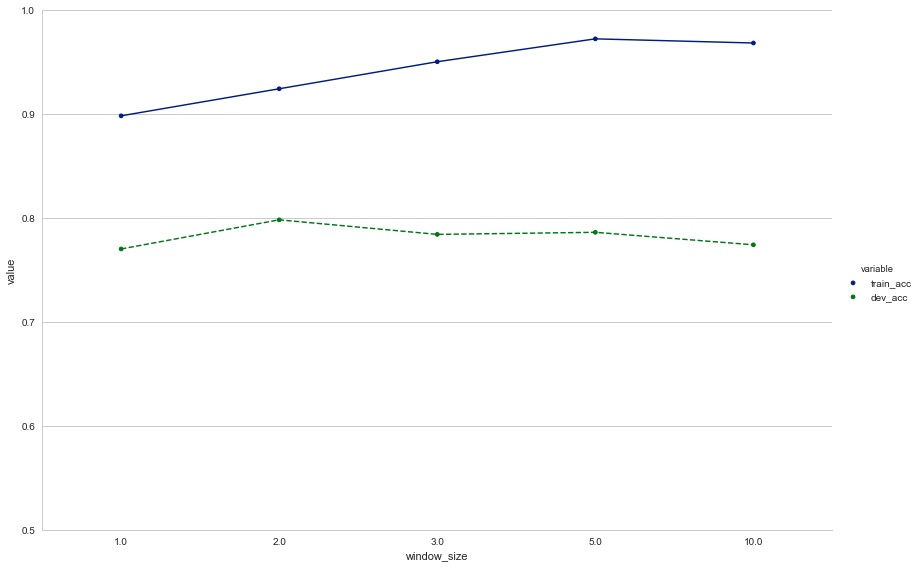

In [356]:
df_window_size = pd.DataFrame(columns=["window_size", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["window_size"]):
    # Model specification
    cnn_model = TextCNN(input_size, embedding_dim, x, n_filters, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_window_size.loc[idx] = [x, train_acc, dev_acc]
print(df_window_size)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_window_size, id_vars=["window_size"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="window_size", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.5, 1))

#### n_filters

   n_filters  train_acc  dev_acc
0        5.0      0.886    0.754
1       10.0      0.936    0.798
2       15.0      0.940    0.784
3       20.0      0.948    0.792
4       50.0      0.962    0.804
5      100.0      0.976    0.776
6      150.0      0.982    0.778
7      200.0      0.984    0.786


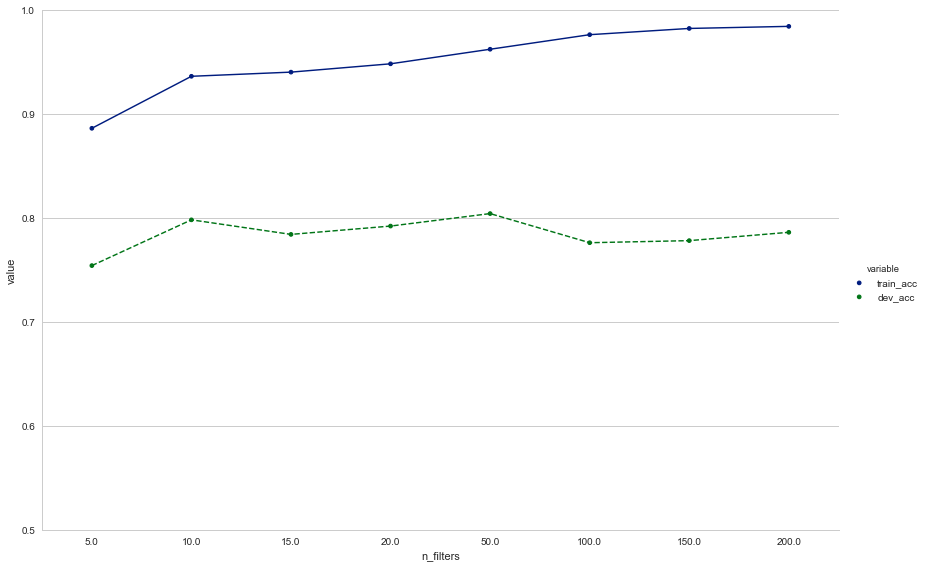

In [363]:
df_n_filters = pd.DataFrame(columns=["n_filters", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["n_filters"]):
    # Model specification
    cnn_model = TextCNN(input_size, embedding_dim, window_size, x, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_n_filters.loc[idx] = [x, train_acc, dev_acc]
print(df_n_filters)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_n_filters, id_vars=["n_filters"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="n_filters", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.5, 1))

#### embedding_dim

   embedding_dim  train_acc  dev_acc
0           10.0      0.880    0.748
1           20.0      0.908    0.822
2           50.0      0.958    0.794
3          100.0      0.974    0.800
4          150.0      0.976    0.776
5          200.0      0.972    0.802
6          300.0      0.982    0.782


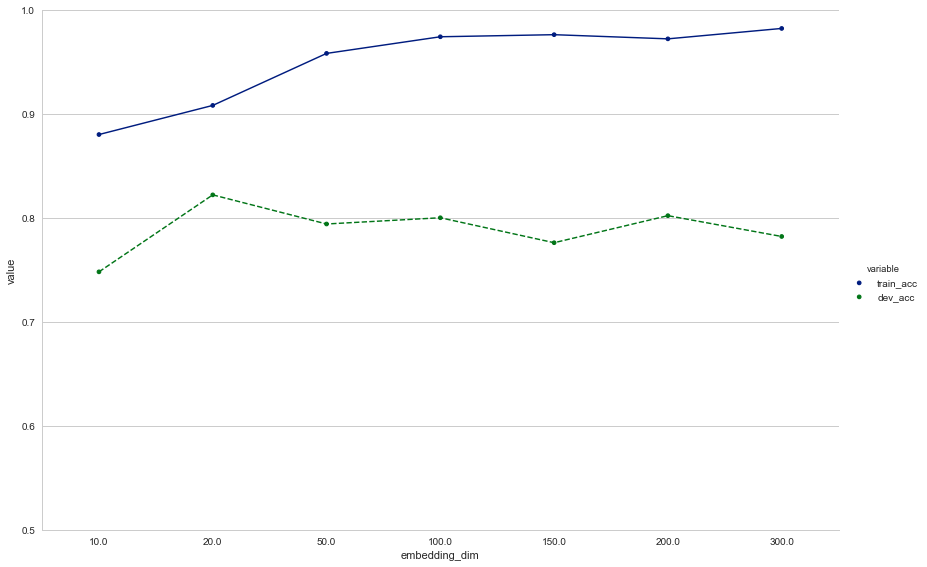

In [359]:
df_embedding_dim = pd.DataFrame(columns=["embedding_dim", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["embedding_dim"]):
    # Model specification
    cnn_model = TextCNN(input_size, x, window_size, n_filters, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_embedding_dim.loc[idx] = [x, train_acc, dev_acc]
print(df_embedding_dim)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_embedding_dim, id_vars=["embedding_dim"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="embedding_dim", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.5, 1))

#### learning_rate

   learning_rate  train_acc  dev_acc
0        0.00001      0.514    0.528
1        0.00010      0.514    0.528
2        0.00100      0.972    0.796
3        0.10000      0.524    0.526
4        1.00000      0.492    0.470


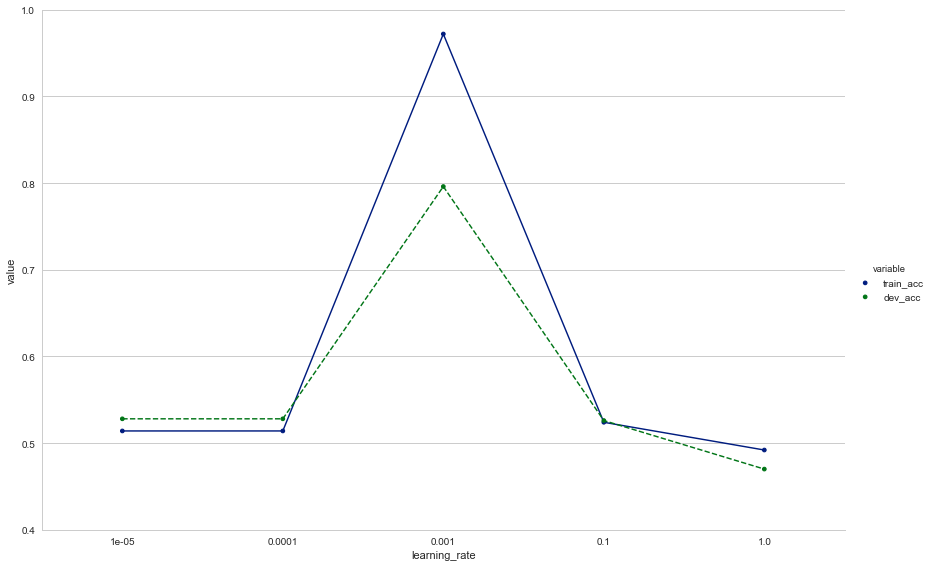

In [360]:
df_learning_rate = pd.DataFrame(columns=["learning_rate", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["learning_rate"]):
    # Model specification
    cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=x)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_learning_rate.loc[idx] = [x, train_acc, dev_acc]
print(df_learning_rate)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_learning_rate, id_vars=["learning_rate"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="learning_rate", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.4, 1))  # Scaling exception

#### dropout_prob

   dropout_prob  train_acc  dev_acc
0          0.10      0.990    0.778
1          0.25      0.988    0.792
2          0.50      0.970    0.778
3          0.75      0.852    0.782
4          0.90      0.514    0.528


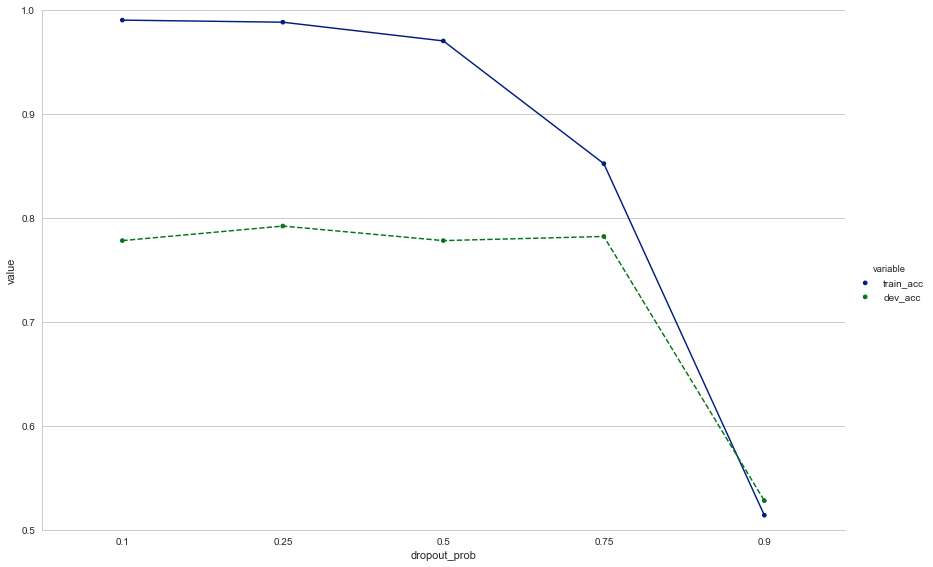

In [330]:
df_dropout_prob = pd.DataFrame(columns=["dropout_prob", "train_acc", "dev_acc"])

for idx, x in enumerate(val_range["dropout_prob"]):
    # Model specification
    cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, x)
    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    train_acc, dev_acc = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter, acc=True)
    # Add final train/dev accuracy
    df_dropout_prob.loc[idx] = [x, train_acc, dev_acc]
print(df_dropout_prob)

# Reformat dataframe for plotting purposes
df_plot = pd.melt(df_dropout_prob, id_vars=["dropout_prob"], value_vars=["train_acc", "dev_acc"])
#print(df_plot)

# Plot
sns.set(style="whitegrid", rc={"lines.linewidth": 0.8}) 
sns.factorplot(x="dropout_prob", y="value", hue="variable", data=df_plot,
                   palette="dark", linestyles=["-", "--"], aspect=1.5, size=8).set(ylim=(0.5, 1))

### 4.

Again, I have kept the parameters in the same order in which they were originally introduced.

For `window_size`, the best overall dev performance was achieved when setting `window_size = 5`. I also tried context windows of size: `[1, 2, 3, 5, 10]`. As expected, the model will start to overfit to the training data the larger the context window becomes, as indicated by the slightly negative correlation between train and dev accuracy. From the plot it actually seems like setting `window_size = 2` instead should be optiomal. To me this seems plausible in the context of a sentiment classification task where the majority of useful features are likely to be single words (e.g. bad, great) or negated words (e.g. not bad, not great).

For `n_filters`, the best overall dev performance was achieved when setting `n_filters = 50`. Other values tested were: `[5, 10, 15, 20, 50, 100, 150, 200]`. Empirically, `n_filters = 50` generally seems to be a good setting. Setting `n_filters = 5` appears to be too few for the model to make accurate predictions. Setting `n_filters = 10` on the other hand seems to work surprisingly well as well, maybe due to the fact that sentiment analysis doesn't require a large amount of latent filters. Otherwise the model also seems to overfit to the training data the more filters are introduced, which again is to be expected.

For `embedding_dim`, the best overall dev performace was achieved when setting `embedding_dim = 100`. As before, I also evaluated the following values: `[10, 20, 50, 100, 150, 200, 300]`. The results for the CNN model actually look very similar to what I found for the CBOW model, so maybe setting `embedding_dim = 200` would indeed improve model accuracy overall. Otherwise the plot indicates that setting `embedding_dim = 20` also works really well, but I'm not sure this is a reliable or even reproducable finding.

For `learning_rate` between `[0.00001, 0.0001, 0.001, 0.1, 1]`, the best overall dev performace was achieved when setting `learning_rate = 0.001`. The CNN plot is an even stronger indication of this being a great default setting. For both train and dev accuracies, model accuracy is very low for values of `[0.00001, 0.0001, 0.1, 1]` and very high for `learning_rate = 0.001`.

For `dropout_prob` between `[0.1, 0.25, 0.5, 0.75, 0.9]`, the best overall dev performace was achieved when setting `dropout_prob = 0.5`. Again, this appears to be true for both the CBOW and the CNN model. The only exception appears to be related to the dev accuracy, which is still comparatively high for `dropout_prob = 0.75`. Otherwise the empirical observations are more or less identical.

### 5.

Of the CBOW hyperparameters that we could vary, below are the ones that consistently achieved around 80% accuracy on `dev` within the first 1000 steps.

```
hidden_dim = 80
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5
```

### 6.

Of the CNN hyperparameters that we could vary, below are the ones that consistently achieved around 80% accuracy on `dev` within the first 1000 steps.

```
window_size = 5
n_filters = 50
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5
```